In [2]:
import nengo
import nengo.spa as spa
import numpy as np
from nengo.spa import Vocabulary
import matplotlib.pyplot as plt

In [3]:
dim = 32  # The dimensionality of the vectors
rng = np.random.RandomState(11)
vocab = Vocabulary(dimensions=dim, rng=rng, max_similarity=0.1)

In [4]:
CIRCLE = vocab.parse("CIRCLE")
BLUE = vocab.parse("BLUE")
RED = vocab.parse("RED")
SQUARE = vocab.parse("SQUARE")
ZERO = vocab.add("ZERO", [0] * dim)

In [5]:
model = spa.SPA(label="Question Answering with Control", vocabs=[vocab])
with model:
    model.visual = spa.State(dim)
    model.motor = spa.State(dim)
    model.memory = spa.State(dim, feedback=1, feedback_synapse=0.1)

    actions = spa.Actions(
        "dot(visual, STATEMENT) --> memory=visual",
        "dot(visual, QUESTION) --> motor = memory * ~visual",
    )

    model.bg = spa.BasalGanglia(actions)
    model.thalamus = spa.Thalamus(model.bg)

    def visual_input(t):
        if 0.1 < t < 0.3:
            return "STATEMENT+RED*CIRCLE"
        elif 0.35 < t < 0.5:
            return "STATEMENT+BLUE*SQUARE"
        elif 0.55 < t < 0.7:
            return "QUESTION+BLUE"
        elif 0.75 < t < 0.9:
            return "QUESTION+CIRCLE"
        return "ZERO"

    # Inputs
    model.input = spa.Input(visual=visual_input)

    visual_probe = nengo.Probe(model.visual.output, synapse=0.01)
    motor_probe = nengo.Probe(model.motor.output, synapse=0.01)

In [9]:
sim = nengo.Simulator(model)
with sim:
    sim.run(1.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

/home/tariq/miniconda3/envs/nengo-tutorials/lib/python3.13/site-packages/nengo/builder/builder.py:239: UserWarning: Object <BasalGanglia "bg"> has already been built.
  warnings.warn(f"Object {obj} has already been built.")
/home/tariq/miniconda3/envs/nengo-tutorials/lib/python3.13/site-packages/nengo/builder/builder.py:239: UserWarning: Object <Thalamus "thalamus"> has already been built.
  warnings.warn(f"Object {obj} has already been built.")


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [10]:
visual = {k : np.dot(sim.data[visual_probe], v) for k, v in zip(vocab.keys, vocab.vectors)}
answer = {k : np.dot(sim.data[motor_probe], v) for k, v in zip(vocab.keys, vocab.vectors)}

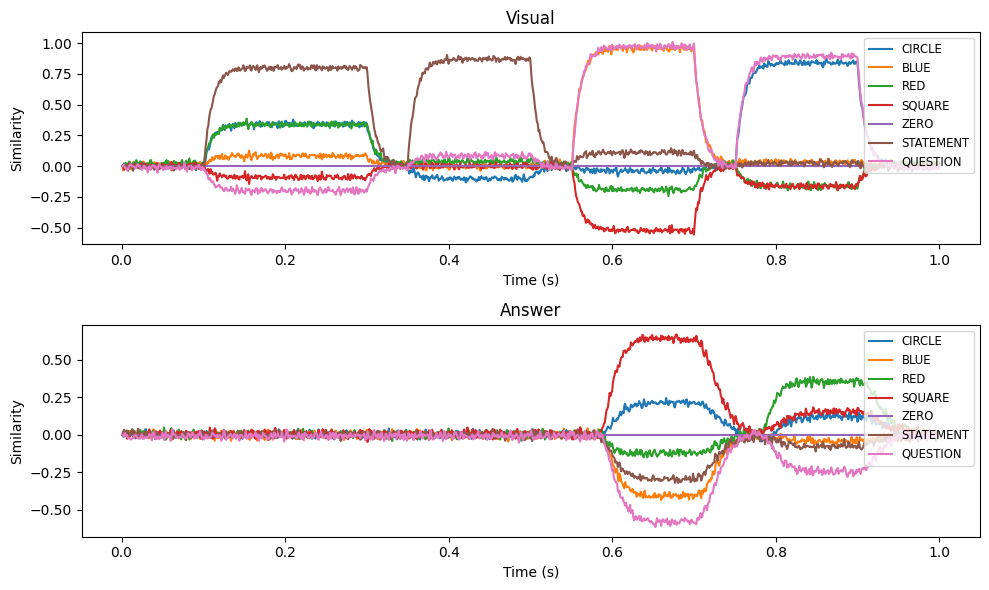

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

data = {"Visual": visual, "Answer": answer}

for ax, (title, d) in zip(axs.flatten(), data.items()):
    for k, v in d.items():
        ax.plot(sim.trange(), v, label=k)
    ax.set_title(title)
    ax.legend(loc="upper right", fontsize="small")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Similarity")

plt.tight_layout()
plt.show()